In [2]:
using DiffEqJump, StochasticDiffEq, DiffEqCallbacks
using StatsBase, Parameters, Plots, Distributions

### Parameters for all Simulations

In [131]:
# functional parameters 
function drift(du,u,p,t) # constant drift
      du .= p.μ
end
function volatility(du,u,p,t) # constant shock exposure
      du .= p.σ
end
function rate_index(u, p, t, index)
   u_max = maximum(u)
   u_min = minimum(u)
   return p.ρ_max* ((u[index] - u_max)^2 / (u_max - u_min))
end
affect_index!(integrator, index) = (integrator.u[index] =
    max(integrator.u[index], integrator.u[rand(1:integrator.p.N)]))

# main params bundle
params = @with_kw (
    μ = 0.01, # mean
    σ = 0.1, # drift
    N = 10, # num particles
    β = 0.2, # rate parameter
    t = 0.:0.01:10., # time steps to save
    moments = Array{Array{Float64, 1}, 1}(), # container for moments
    α = 2.0, # shape parameter for the initial condition distribution
    iv_dist = Exponential(1/α), # updates based on supplied α
    trajectories = 2, # number of members for ensemble methods 
    jump_algorithm = SRIW1(), # jump diffeq algorithm
    drift = drift, 
    rate_index = rate_index,
    volatility = volatility,
    affect_index! = affect_index!,
    ρ_max = 2.0)

#189 (generic function with 2 methods)

### Generator Functions for Problem Objects

In [132]:
struct AffectIndex{F1, F2}
    affect_index!::F1
    index::F2
end
function (p::AffectIndex)(integrator)
    return p.affect_index!(integrator, p.index)
end
struct RateIndex{F1, F2}
    rate_index::F1
    index::F2
end
function (q::RateIndex)(u, p, t)
    return q.rate_index(u, p, t, q.index)
end

function generate_jump_prob(p)
    x_iv = rand(p.iv_dist, p.N) # draw initial condition
    sde_prob = SDEProblem(p.drift, p.volatility, x_iv, (0.0, p.t[end]), p)
    jumps = [VariableRateJump(RateIndex(p.rate_index, i), AffectIndex(p.affect_index!, i)) for i in 1:p.N];
    jump_prob = JumpProblem(sde_prob, Direct(), JumpSet((jumps),(),nothing,nothing))
    return jump_prob
end

function generate_ensemble_prob(p)
    prob = generate_jump_prob(p)
    function write_moments(sol, i)
        newsol = DiffEqBase.build_solution(sol.prob, sol.alg, sol.prob.p.t, sol.prob.p.moments)
        return newsol, false
    end
    function calculate_moments(u, t, integrator) 
        g = (length(integrator.p.moments) == 0. ? 0. : (mean(u) - integrator.p.moments[end][2])/step(integrator.p.t))
        moments = [minimum(u), mean(u), maximum(u), g]
        push!(integrator.p.moments, moments) 
    end
    cb = FunctionCallingCallback(calculate_moments; funcat=p.t, func_everystep=false, func_start = true, tdir=1);
    ensemble_prob = EnsembleProblem(prob, output_func = write_moments)    
    return ensemble_prob, cb
end
    
p = params();

### Ensemble Aggregates

Run several simulations, and track the mean of their moments over time.

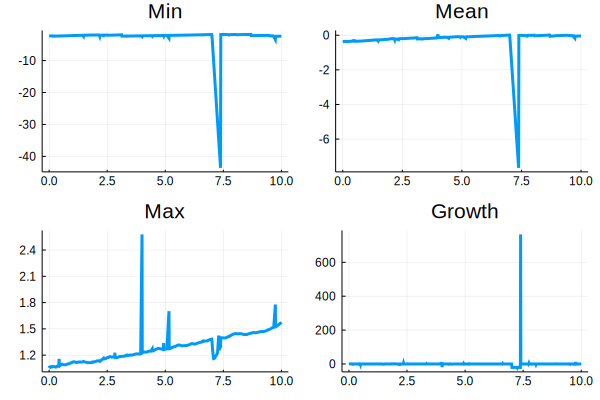

In [145]:
ensemble_prob, cb = generate_ensemble_prob(p)
sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)

p1 = plot(summ, idxs = [1], error_style = :none, title = "Min")
p2 = plot(summ, idxs = [2], error_style = :none, title = "Mean")
p3 = plot(summ, idxs = [3], error_style = :none, title = "Max")
p4 = plot(summ, idxs = [4], error_style = :none, title = "Growth")

plot(p1, p2, p3, p4)

### Ensemble Trajectories

Run several ensembles, and track the means of the _n_th particle's position over time.

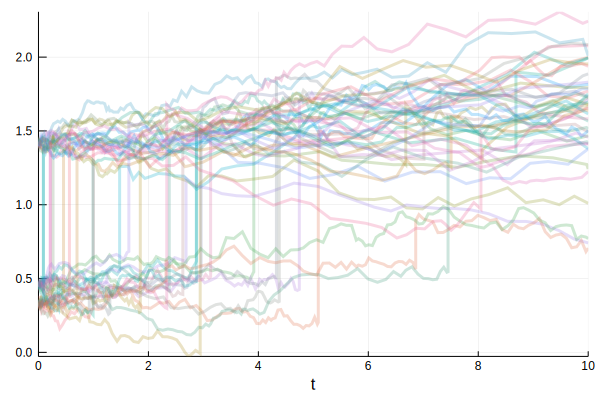

In [154]:
p = params(N = 3, trajectories = 15)
ensemble_prob = EnsembleProblem(generate_jump_prob(p)) # no callback structure, since we care about positions and not moments
sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories)
plot(sim, alpha = 0.25)

### Single Simulation

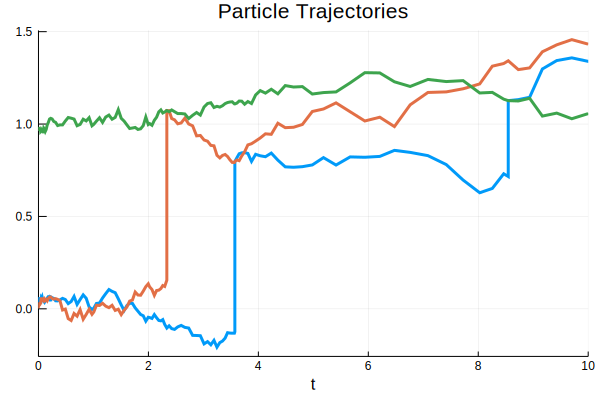

In [155]:
p_single = params(N = 3)
jump_prob = generate_jump_prob(p_single)
sol = solve(jump_prob, p.jump_algorithm)
plot(sol, legend = false, title = "Particle Trajectories")